In [1]:
#线性回归的从零开始实现
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [18]:
#使用线性模型参数构造数据集

''' 
当我们的输⼊包含d个特征时，我们将预测结果ˆy （通常使⽤“尖⻆”符号表⽰y的估计值）表⽰为：
ˆy = w1x1 + ... + wdxd + b    (3.1.2)

将所有特征放到向量x ∈ Rd中，并将所有权重放到向量w ∈ Rd中，我们可以⽤点积形式来简洁地表达模型：
ˆy = w⊤x + b    (3.1.3)

在 (3.1.3)中，向量x对应于单个数据样本的特征。⽤符号表⽰的矩阵X ∈ Rn×d 
可以很⽅便地引⽤我们整个数据集的n个样本。
其中，X的每⼀⾏是⼀个样本，每⼀列是⼀种特征。
对于特征集合X，预测值ˆy ∈ Rn 可以通过矩阵-向量乘法表⽰为：
ˆy = Xw + b    (3.1.4)
'''

#定义人造数据函数
def synthetic_data(w, b, num_examples): #@save
    """⽣成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) #从均值为0，方差为1的正态分布中提取随机数的张量
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) #添加误差
    return X, y.reshape((-1, 1)) #-1表示所有行


In [19]:
# 构建人造数据
true_w = torch.tensor([2, -3.4]) #数据类型为列表
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [20]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.0947, -1.2870]) 
label: tensor([8.7731])


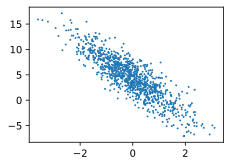

In [21]:
d2l.set_figsize() #设置图片大小，生成第二个特征和labels的散点图
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [22]:
#抽取小批量数据集，打乱数据集中的样本并以小批量方式获取数据
#获取批数据，生成特征与标签
#带yield的函数才是真正的迭代器
def data_iter(batch_size, features, labels):
    num_examples = len(features)  # X长度，构建索引
    indices = list(range(num_examples))  #随机索引
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices) #将索引打乱顺序
    for i in range(0, num_examples, batch_size): #开始，停止，步长
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
    yield features[batch_indices], labels[batch_indices] #return generator


In [23]:
batch_size = 10
#读取第一个小批量样本数据并打印
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.6123, -0.2734],
        [ 0.7082,  0.5498],
        [-1.9942,  0.5942],
        [ 0.8044, -0.2328],
        [-0.8727,  0.6125],
        [ 0.1065,  0.4152],
        [ 0.8017, -2.6140],
        [ 0.1632,  0.2744],
        [-0.8131,  0.5399],
        [-0.9419,  0.0982]]) 
 tensor([[ 6.3511],
        [ 3.7433],
        [-1.8088],
        [ 6.5997],
        [ 0.3742],
        [ 3.0039],
        [14.6938],
        [ 3.5904],
        [ 0.7277],
        [ 1.9952]])


In [24]:
#初始化模型参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) #正态分布
b = torch.zeros(1, requires_grad=True) #偏执为0

In [25]:
#定义模型
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [26]:
#定义损失函数
def squared_loss(y_hat, y): #@save
    """均⽅损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2 #平方损失

In [27]:
#定义优化算法 stochastic gradient descent 随机梯度下降 更新
def sgd(params, lr, batch_size): #@save
    """⼩批量随机梯度下降""" 
    with torch.no_grad():
        for param in params: #lr 学习速率  批量大小、学习率为超参
            param -= lr * param.grad / batch_size #更新参数  w-学习率*偏导/批量
            param.grad.zero_()   #计算小批量的平均损失关于模型参数的导数 梯度清空

In [28]:
#训练
#读取小批量样本，模型预测，计算损失，反向传播，存储梯度，优化更新
#初始化参数
lr = 0.03
num_epochs = 3
net = linreg    #网络，线性回归模型
loss = squared_loss #损失，平方损失

In [29]:
#周期迭代
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels): #遍历数据集，获取批数据特征与标签
        l = loss(net(X, w, b), y) # X和y的⼩批量损失
        # 因为l形状是(batch_size,1)，⽽不是⼀个标量。
        # l中的所有元素被加到⼀起，并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) #优化（更新）算法，使⽤参数的梯度更新参数
    with torch.no_grad(): #强制之后的内容不进行计算图构建
        train_l = loss(net(features, w, b), labels) #还是损失函数，但不需要保留梯度
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}') 
        #f''，格式化字符串，可在字符串中使用花括号括起来的变量和表达式
        #:f , 以标准格式输出一个浮点数,不能单独使用，只能用在f格式化输出里面
        #mean()，损失均值

epoch 1, loss 17.547232
epoch 2, loss 16.404228
epoch 3, loss 14.491063


In [30]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 1.7758, -2.9868], grad_fn=<SubBackward0>)
b的估计误差: tensor([3.7442], grad_fn=<RsubBackward1>)
